# Задание 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

### Начальные условия

In [3]:
r = 0.01                                            # Радиус неоднородности в виде шара
mu_a = np.array([32, 23, 40, 23, 46, 51])           # Коэффициенты поглощения слоев (мю a)
mu_s = np.array([165, 227, 246, 227, 253, 186])     # Коэффициенты рассеяния слоев (мю s)
g = np.array([0.72, 0.72, 0.72, 0.72, 0.72, 0.8])   # Факторы анизотропии слоев
d = np.array([0.01, 0.02, 0.02, 0.09, 0.06, 2 * r]) # Толщины слоев. Для шара = диаметр (r * 2)

sum_of_d = np.sum(d[:5])    # Общая глубина (= 0.2)
l = 0.02                    # Глубина центра шара неоднородности

mu = mu_a + mu_s
p_a = mu_a / mu             # Вероятность поглощения фотона

N = 10000                   # Количество моделируемых фотонов
W = np.ones(N)              # Начальные веса фотонов (= 1)
Wp = 0.00001                # Пороговое значение веса 10 в -4
m = 10

transmissioned_photons = 0  # Количество фотонов, которые прошли через ткань
reflected_photons = 0       # Количество фотонов, которые были отражены
absorped_photons = []       # Таблица поглощенных фотонов (X, Z (глубина), W (вес))

In [4]:
# Функция Хени-Гринштейна
def henyey_greenstein(cos_theta, g):
    return (1 - g**2) / (2 * (1 + g**2 - 2 * g * cos_theta)**(3 / 2))

In [5]:
# Получение cos(theta)
def gen_cos_theta(g_val):
    u = np.random.uniform(0, 1)
    if g_val == 0:
        return 2 * u - 1
    else:
        return (1 + g_val**2 - ((1 - g_val**2)/(1 - g_val + 2*g_val*u))**2)/(2*g_val)

In [6]:
def layer(photon):
    layer_number = 0
    if photon[0]**2 + photon[1]**2 + (photon[2] - l)**2 <= r**2:    # Неоднородность (Слой 6)
        layer_number = 5
    elif 0 <= photon[2] <= d[0]:     # Слой 1
        layer_number = 0
    elif d[0] < photon[2] <= d[1]:   # Слой 2
        layer_number = 1
    elif d[1] < photon[2] <= d[2]:   # Слой 3
        layer_number = 2
    elif d[2] < photon[2] <= d[3]:   # Слой 4
        layer_number = 3
    elif d[3] < photon[2] <= d[4]:   # Слой 5
        layer_number = 4
    return layer_number

In [7]:
# Моделирование N фотонов
for i in range(N):
    photon = np.array([0.0, 0.0, 0.0])  # Координаты фотона X, Y, Z
    vx, vy, vz = 0, 0, 1                # Текущее направление фотона vx, vy, vz
    j = 1

    while True:
        # Определение слоя, в котором находится фотон   
        layer_number = layer(photon)

        # Условие поглощения фотона
        if (j != 1) and (np.random.uniform() < p_a[layer_number]):
            absorped_photons.append([photon[0], photon[2], W[i]])       # X, Z (глубина), W (вес)
            break

# ======================================================================================================================================== 
        cos_theta = gen_cos_theta(g[layer_number])
        theta = np.arccos(cos_theta)             
        phi = np.random.uniform(0, 2 * np.pi)        # Угол отклоненияния

        if (j == 1):
            current_v = np.array([0, 0, 1])          # Текущее направление фотона     
        else:
            current_v = np.array([vx, vy, vz])       
            
        if (j == 1):            
            s = np.random.exponential(1 / mu[layer_number])
            new_v = np.array([0, 0, 1])
            photon += new_v * s

        else:
            if abs(vz) == 1:        # Фотон движется строго по оси Z
                vx = np.sin(theta) * np.cos(phi)
                vy = np.sin(theta) * np.sin(phi)
                vz = np.sign(vz) * cos_theta
                new_v = np.array([vx, vy, vz])
            else:
                sin_theta = np.sin(theta)
                sin_phi = np.sin(phi)
                cos_phi = np.cos(phi)
                # Вычисляем компоненты нового направления
                new_vx = vx * cos_theta + (sin_theta / np.sqrt(1 - vz**2) * (vx * vz * cos_phi - vy * sin_phi))
                new_vy = vy * cos_theta + (sin_theta / np.sqrt(1 - vz**2) * (vy * vz * cos_phi + vx * sin_phi))
                new_vz = vz * cos_theta + sin_theta * cos_phi * np.sqrt(1 - vz**2)
                new_v = np.array([new_vx, new_vy, new_vz])
                # Обновляю значение vx, vy, vz
                vx = new_vx 
                vy = new_vy
                vz = new_vz

            # Генерация длины пробега фотона - по показательному закону с параметром = mu_a + mu_s
            s = np.random.exponential(1 / mu[layer_number])
            photon += new_v * s  # Запись новых координат фотона

# ========================================================================================================================================
        # Условие отражения фотона обратно вверх
        if photon[2] < 0:
            reflected_photons += 1
            break

        # Условие прохождения фотона через все ткани вглубь
        if photon[2] > sum_of_d:
            transmissioned_photons += 1   
            break
            
        layer_number = layer(photon)    
        W[i] -= W[i] * mu_a[layer_number] / mu[layer_number]   # Уменьшение статистического веса фотона после акта взаимодействия

        # Условие достижения статистического веса фотона порогового значения                                                   
        if W[i] <= Wp:
            if np.random.uniform() < (1 / m):                  # Условие поглощения или продолжения движения фотоном с новым весом
                W[i] = m * W[i]
            else:                                              # Иначе добавление поглощенного фотона в таблицу
                absorped_photons.append([photon[0], photon[2], W[i]])
                break
        j += 1

In [8]:
# Коэффициенты пропускания и отражения среды
print(f"Коэффициент пропускания среды (доля фотонов, прошедших через ткань): {transmissioned_photons / N}")
print(f"Коэффициент отражения среды (доля отраженных фотонов): {reflected_photons / N}")

# Визуализация распределения поглощенных фотонов
absorbed_photons = np.array(absorped_photons)
xlim = [-0.06, 0.06]
zlim = [-0.01, 0.21]

Коэффициент пропускания среды (доля фотонов, прошедших через ткань): 0.0
Коэффициент отражения среды (доля отраженных фотонов): 0.1116


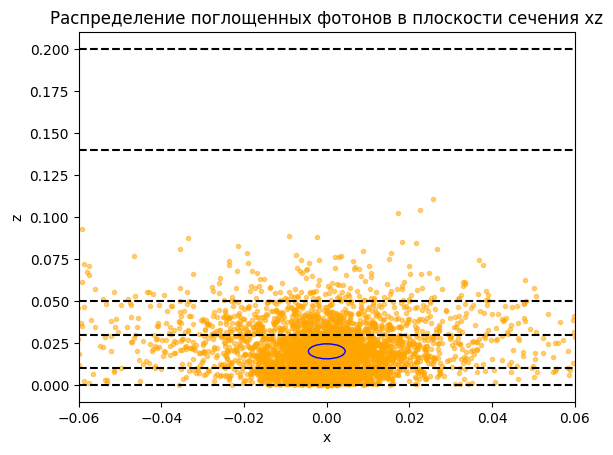

In [9]:
plt.figure()
plt.scatter(absorbed_photons[:, 0], absorbed_photons[:, 1], c='orange', marker='.', alpha=0.5)
plt.title("Распределение поглощенных фотонов в плоскости сечения xz")
plt.xlabel("x")
plt.ylabel("z")
plt.xlim(xlim)
plt.ylim(zlim)

# Рисование слоев
layers = np.cumsum(np.insert(d[:5], 0, 0))
for h in layers:
    plt.axhline(h, color='black', linestyle='--')

# Рисование шара
circle = Circle((0, l), r / 2.25, color='blue', fill=False)
plt.gca().add_patch(circle)

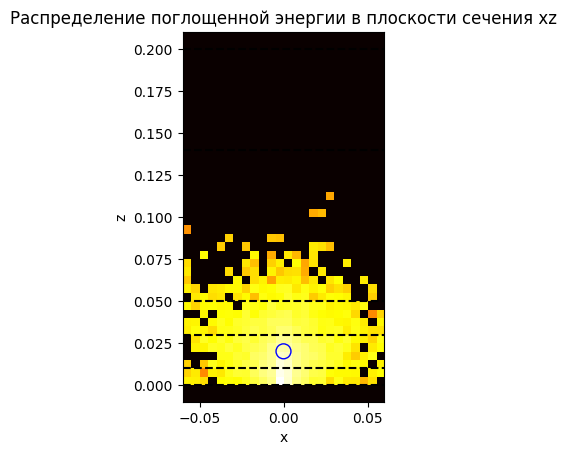

In [10]:
# Визуализация распределения поглощенной энергии
step = 0.005
# Создание массивов x и z для построения сетки
x = np.arange(xlim[0], xlim[1] + step, step)
z = np.arange(zlim[0], zlim[1] + step, step)
absorbed_energy_map = np.zeros((len(x) - 1, len(z) - 1))    # Инициализация карты поглощенной энергии

# Заполнение карты поглощенной энергии. [x, z, W] для одного поглощенного фотона
for k in range(absorbed_photons.shape[0]):
    i = int((absorbed_photons[k, 0] - xlim[0]) // step)
    j = int((absorbed_photons[k, 1] - zlim[0]) // step)
    if 0 <= i < absorbed_energy_map.shape[0] and 0 <= j < absorbed_energy_map.shape[1]:
        # Добавляю энергию текущего фотона в соответствующую ячейку карты
        # absorbed_energy_map[i, j] - ячейка карты, соответствующая координатам (x, z)
        # absorbed_photons[k, 2] - энергия k-го фотона
        absorbed_energy_map[i, j] += absorbed_photons[k, 2]

plt.figure()
plt.imshow(np.log(absorbed_energy_map.T + 1e-10), extent=[xlim[0], xlim[1], zlim[0], zlim[1]], origin='lower', cmap='hot')
plt.title("Распределение поглощенной энергии в плоскости сечения xz")
plt.xlabel("x")
plt.ylabel("z")

# Рисование слоев
for h in layers:
    plt.axhline(h, color='black', linestyle='--')

# Рисование шара
circle = Circle((0, l), r / 2.25, color='blue', fill=False)
plt.gca().add_patch(circle)

plt.show()